## 5、卷积神经网络

### 5.1 卷积

卷积运算相当于图像处理中的“滤波器运算”，将各个位置上滤波器的元素和输入的对应元素相乘，再求和（也称为乘积累加运算），再将最后的结果保存到输出的对应位置。移动滤波器，遍历图片所有的位置得到卷积运算的输出。偏置通常只有1个（1 × 1）（下图中，滤波器输出是4个数据，偏置只有1个），这个值会被加到应用了滤波器的所有元素上。

<img src="./notebook-imgs/conv-1.png" width="800">

In [17]:
# 图中卷积运算的实现
%reload_ext autoreload
%autoreload 2
from src.util import *
import numpy as np

x = np.array(
    [[1,2,3,0],
     [0,1,2,3],
     [3,0,1,2],
     [2,3,0,1]]
)

w = np.array(
    [[2,0,1],
     [0,1,2],
     [1,0,2]
    ]
)

conv_param = {'stride':1, 'pad':0}
b = np.array([3])

x = x.reshape(1,1,4,4)  # 只增加维度，数据本身没变
w = w.reshape(1,1,3,3)
out, _ = conv_forward_fast(x, w, b, conv_param)
print('conv with bias=3 :')
print(out)

conv with bias=3 :
[[[[18. 19.]
   [ 9. 18.]]]]


### 5.2 填充（padding）

使用填充主要是为了调整输出的大小，因为卷积运算会缩小空间，如果模型只有卷积操作，最终会在某个层输出大小变为 1，导致无法再应用卷积运算。在下图的例子中，对大小为(4, 4)的输入数据应用了幅度为1的填充。“幅度为1的填充”是指上下、左右各填充一个像素，填充的像素值通常为0。

<img src="./notebook-imgs/conv-2-pad.png" width="600">

In [18]:
conv_param = {'stride':1, 'pad':1}    # pad设为1
b = np.array([0])
out, _ = conv_forward_fast(x, w, b, conv_param)
print('conv with pad=1 :')
print(out)

conv with pad=1 :
[[[[ 7. 12. 10.  2.]
   [ 4. 15. 16. 10.]
   [10.  6. 15.  6.]
   [ 8. 10.  4.  3.]]]]


### 5.3 步幅（stride）
滤波器每次移动的间隔称为步幅（stride）。默认步幅都是1，如果将步幅设为2，如下图所示，应用滤波器窗口的间隔变为2个像素。

<img src="./notebook-imgs/conv-3-stride.png" width="400">

增大填充后，输出大小会变大；增大步幅后，输出大小会变小，可以将填充和步幅结合起来控制输出大小。假设输入图片大小为(H, W)，滤波器大小为(FH, FW)，输出大小为(OH, OW)，填充为P，步幅为S，输出的特征图大小可通过以下公式进行计算。

$OH = \left \lfloor \frac{H+2*P-FH}{S} \right \rfloor + 1$

In [19]:
x = np.array(
    [
        [1, 2, 3, 0, 1, 2, 3],
        [0, 1, 2, 3, 0, 1, 2],
        [3, 0, 1, 2, 3, 0, 1],
        [2, 3, 0, 1, 2, 3, 0],
        [1, 2, 3, 0, 1, 2, 3],
        [0, 1, 2, 3, 0, 1, 2],
        [3, 0, 1, 2, 3, 0, 1]
    ]
)
x = x.reshape(1,1,7,7) 
conv_param = {'stride':2, 'pad':0} 
b = np.array([0])
out, _ = conv_forward_fast(x, w, b, conv_param)
print('conv with stride=2 : output size is ', conv_output_size(x.shape[3], w.shape[3], 2, 0))
print(out)

conv with stride=2 : output size is  3
[[[[15. 17. 15.]
   [17. 15. 17.]
   [15. 17. 15.]]]]


### 5.4 三维数据的卷积运算
前面卷积运算的例子都是2维数据，只有长宽两个方向。通常用到的数据是3维彩色图片，除了长宽之外，还需要处理通道。

卷积中，通常kernel是指单个二维权重矩阵，而filter是一组kernel。在处理三维数据时，输入数据和滤波器的通道数要设为相同的值，如下图所示，输入是3通道，卷积层的单个filter也要是3通道，即3个kernel。输入数据的3通道数据分别与3个kernel做卷积，结果再相加得到一个2维输出即一张特征图。下图中输入是3通道，输出1通道（输出一个特征图），只有一个filter，该filter有3个kernel，filter的个数和输出通道数一致。

<img src="./notebook-imgs/conv-4-3d.png" width="600">

通常卷积层是有多个filter，即输出有多个特征图。下图是多个特征图时滤波器数目和输出的关系，图中卷积层有FN个滤波器即FN个filter，输出特征图是FN个，最后的输出形状为(FN, OH, OW)的方块。将这个方块传给下一层，就是CNN的处理流。

<img src="./notebook-imgs/conv-4-fn.png" width="600">

### 5.5 批处理

批处理，即一次处理多张图片，通过批处理，能够充分利用处理器的计算性能。通常将输入按(batch_num, channel, height, width)的顺序组织为4维数据，批处理将N次的处理汇总成了1次进行。

下图是批处理流程，注意滤波器的维度和输出数据的维度，再就是偏置b，偏置是在卷积完成之后再进行相加，是每个特征图（每个输出通道）对应1个偏置，特征图的每个像素都要加上偏置，不同特征图的偏置不同。

<img src="./notebook-imgs/conv-5-batch.png" width="800">

In [24]:
# 4维数据卷积结果校验
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward
difference:  2.2121476417505994e-08


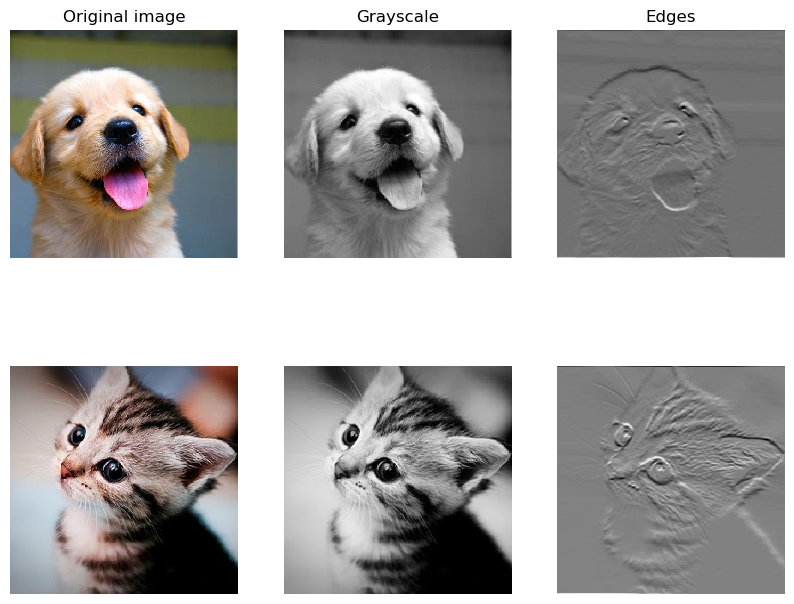

In [21]:
# 图片卷积处理后的效果，可以提取物体轮廓
%matplotlib inline
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from imageio.v2 import imread
from PIL import Image

kitten = imread('./notebook-imgs/kitten.jpg')
puppy = imread('./notebook-imgs/puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
resized_puppy = np.array(Image.fromarray(puppy).resize((img_size, img_size)))
resized_kitten = np.array(Image.fromarray(kitten_cropped).resize((img_size, img_size)))
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = resized_puppy.transpose((2, 0, 1))
x[1, :, :, :] = resized_kitten.transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_fast(x, w, b, {'stride': 1, 'pad': 1})

def imshow_no_ax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_no_ax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_no_ax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_no_ax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_no_ax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_no_ax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_no_ax(out[1, 1])
plt.show()

### 5.6 卷积的快速实现

以上代码中，卷积实现使用的conv_forward_fast函数，该函数使用im2col函数实现了卷积的快速计算，im2col将4维的输入数据展开成2维矩阵以适合滤波器（权重），同时将滤波器展开为2维矩阵（每个filter展开为一列），最后只要通过一次矩阵乘法即可算出结果。同时numpy对于矩阵乘法做了大量优化，性能很高，可以大大提高卷积的计算速度。

经过im2col展开后的元素个数会多于输入图片的的像素个数，因为很多像素会多次用到，会重复排列在矩阵的不同位置，会消耗更多的内存，以空间换时间。深度学习框架的卷积大都使用了im2col方法。

<img src="./notebook-imgs/im2col.png" width="600">

### 5.7 卷积反向传播计算

卷积操作反向传播的推导和计算稍显复杂，有兴趣的同学可以查阅相关参考资料，实验不做要求。

1. [CNN_Backprop_Recitation](https://deeplearning.cs.cmu.edu/F21/document/recitation/Recitation5/CNN_Backprop_Recitation_5_F21.pdf)

2. [Backpropagation in a convolutional layer](https://towardsdatascience.com/backpropagation-in-a-convolutional-layer-24c8d64d8509)

下面是卷积反向传播实现的正确性校验，与数值微分的结果做对比，dx,dw,db的误差小于e-8。

In [22]:
# 反向传播计算结果校验
np.random.seed(231)
x = np.random.randn(4, 3, 7, 7) 
w = np.random.randn(2, 3, 3, 3)
f = w.shape[0]
b = np.random.randn(f,)

conv_param = {'stride': 1, 'pad': 1}  
out, cache = conv_forward_fast(x, w, b, conv_param)   # 
dout = np.random.randn(*out.shape) 

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_fast(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_fast(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_fast(x, w, b, conv_param)[0], b, dout)

dx, dw, db = conv_backward_fast(dout, cache)

# Your errors should be around e-8 or less.
print('Testing conv_backward function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward function
dx error:  6.63722618401759e-09
dw error:  2.531886698999555e-10
db error:  2.7767474483678322e-11


实验要求大家实现普通的卷积运算src/util.py中的`conv_forward_naive`函数，并替换以上所有代码块中的conv_forward_fast完成测试（反向传播测试需要改用conv_backward_naive函数）。NumPy中，用for访问元素一个个计算会比较慢，可以使用NumPy的向量化特性加速运算。

### 5.8 卷积神经网络的训练

`src/simple_convnet.py`中实现了一个简单的卷积神经网络，网络结构如下，affine即全连接层。

`conv - relu - pool - affine - relu - affine - softmax`

参考`train_fcnet.py`实现`src/train_convnet.py`，完成卷积神经网络的训练，能够输出训练日志或者画出accuracy曲线。

In [28]:
!cd src && python train_convnet.py

Iteration 0, Loss: 2.302554363067506
Iteration 100, Loss: 2.3019276022243855
Iteration 200, Loss: 2.124561111178541
Iteration 300, Loss: 0.40754315484281706
Iteration 400, Loss: 0.2465391694688104
Iteration 500, Loss: 0.16963257397221895
Iteration 600, Loss: 0.25932967233358395
Iteration 700, Loss: 0.24195093646243207
Iteration 800, Loss: 0.08049511564092703
Iteration 900, Loss: 0.1546691458371373
Iteration 1000, Loss: 0.07997066491426391
Iteration 1100, Loss: 0.09448413593251508
Iteration 1200, Loss: 0.0782494371018441
Iteration 1300, Loss: 0.11379674167491997
Iteration 1400, Loss: 0.05681209088007015
Iteration 1500, Loss: 0.06267119231920762
Iteration 1600, Loss: 0.07568485254672183
Iteration 1700, Loss: 0.05234640038025116
Iteration 1800, Loss: 0.02981502313683141
Iteration 1900, Loss: 0.07453897468453068
Iteration 2000, Loss: 0.03606612038836604
Iteration 2100, Loss: 0.0862582717622328
Iteration 2200, Loss: 0.0414467971924583
Iteration 2300, Loss: 0.031932085695641904
Iteration 240

本节要完成的内容:

1. 实现src/util.py中的conv_forward_naive，并替换4.5节第一个cell中的conv_forward_fast完成测试。
2. 实现src/train_convnet.py，参考train_fcnet.py完成卷积神经网络`SimpleConvNet`训练，要求test acc的准确率达到90%以上。
3. 选做（最多可加10分（百分制））： 从[Flower Dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/)中自行构造训练集和测试集，改造train_convnet.py完成花卉识别，类别数不少于6，测试集的准去率不低于90%。